<p style="background-color:#D9EDF7">
This was mostly good, but there were a couple errors that lead to wrong values for your Kd. Under the square root for the equation for F, you missed the term -4*50*cb[i]. Also, you should have had -delta_G in the exp, not delta_G. Other wise, this looked good, so I'll just take off 1 point from each model for the errors in the code. Overall, 18/20
</p>

### Credits: 
Jared - pretty much everything, Maria wrote some priors that didn't end up being used.

### Problem 9.2: Outliers in FRET binding curve, 20 pts

We often want to ascertain how tightly two proteins are bound by measuring their dissociation constant, $K_d$.  This is usually done by doing a titration experiment and then performing a regression.  For example, imagine two proteins, a and b may bind to each other in the reaction

\begin{align}
\text{ab} \rightleftharpoons \text{a} + \text{b}
\end{align}

with dissociation constant $K_d$.  At equilibrium

\begin{align}
K_d = \frac{c_a\,c_b}{c_{ab}},
\end{align}

were $c_i$ is the concentration of species $i$.  If we add known amounts of a and b to a solution such that the total concentration of a is $c_a^0$ and the total concentration of b is $c_b^0$, we can compute the equilibrium concentrations of all species.  Specifically, in addition to the equation above, we have conservation of mass equations,

\begin{align}
c_a^0 &= c_a + c_{ab}\\[1em]
c_b^0 &= c_b + c_{ab},
\end{align}

fully specifying the problem.  We can solve the three equations for $c_{ab}$ in terms of the known quantities $c_a^0$ and $c_b^0$, along with the parameter we are trying to measure, $K_d$.  We get

\begin{align}
c_{ab} = \frac{2c_a^0\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}}.
\end{align}

The technique, then, is to hold $c_a^0$ fixed in the experiment and measure $c_{ab}$ for various $c_b^0$. We can then perform a regression to get $K_d$.

In order to do this, though, we need some readout of $c_{ab}$. For this problem, we will use FRET (fluorescence resonance energy transfer) to monitor how much of a is bound to b.  Specifically, we consider a to have a fluorophore and b to be its receptor.  When the two are unbound, we get a fluorescence signal per molecule of $f_0$.  When they are bound, the receptor absorbs the light coming out of the fluorophore, so we get less fluorescence per molecule, which we will call $f_q$ (for "quenched").  Let $f$ be the total per-fluorophore fluorescence signal.  Then, the measured fluorescence signal, $F$, is

\begin{align}
F = c_a^0\,V f = \left(c_a \,f_0 + c_{ab}\, f_q\right)V,
\end{align}

where $V$ is the reaction volume. We can absorb $V$ into the other parameters such that $\hat{f}_0 = f_0 V$ and $\hat{f}_q = f_q V$, giving

\begin{align}
F = \hat{f}_0(c_a^0 - c_{ab}) + \hat{f}_q\, c_{ab}
= \hat{f}_0\,c_a^0 - \frac{2(\hat{f}_0 - \hat{f}_q)c_a^0\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}}.
\end{align}

Compute parameter estimates for $K_d$ with and without an outlier detection scheme for [this data set](../data/fret_binding_curve.csv). How do the results differ depending on whether or not you were trying to detect outliers?

*Note*: These are real data, but they are from an unpublished experiment here on campus. I therefore have not exposed the identities of the proteins a and b.

In [144]:
import glob
import os
import sys

import numpy as np
import pandas as pd
import scipy.signal

# Import Altair for high level plotting
import altair as alt
import altair_catplot as altcat

# Pevent bulky altair plots
alt.data_transformers.enable('json')

import bebi103
import bokeh
from bokeh.palettes import all_palettes
import itertools
from bokeh.models import Legend, LegendItem
bokeh.io.output_notebook()

Loading BokehJS ...

First let's read in the data:

In [145]:
df = pd.read_csv("../data/fret_binding_curve.csv", comment = '#')
df

buffer  fluorescence  a conc (nM)  b conc (nM)
0  1256.5751   258316.2818         50.0  1500.000000
1  1256.5751   267722.6277         50.0   750.000000
2  1256.5751   267431.6620         50.0   375.000000
3  1256.5751   284596.2914         50.0   187.500000
4  1256.5751   254903.3958         50.0    93.750000
5  1256.5751   333810.6371         50.0    46.875000
6  1256.5751   370821.7778         50.0    23.437500
7  1256.5751   408856.1424         50.0    11.718750
8  1256.5751   431000.0000         50.0     5.859375
9  1256.5751   437000.0000         50.0     0.000000

And take a look:

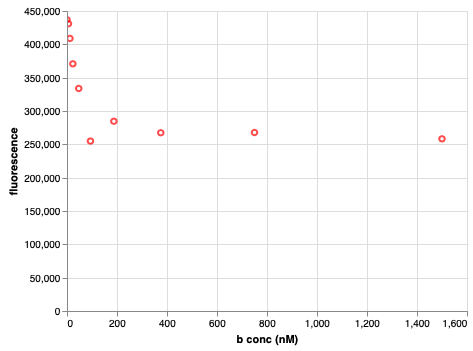

In [146]:
plot1 = alt.Chart(df).mark_point(color='red').encode(
        x = alt.X("b conc (nM)"),
        y = alt.Y("fluorescence")
        ).interactive()
plot1

Hmmm I wonder if there are any outliers haha.

Given our known quantities and our goal, the relevant equation is:
\begin{align}
F
= \hat{f}_0\,c_a^0 - \frac{2(\hat{f}_0 - \hat{f}_q)c_a^0\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}}.
\end{align}

The concentration of a is a set quantity in this experiment and that of b is our independent variabl, so we need parameter estimates of $K_d$, $\hat{f}_0$, and $\hat{f}_q$. Additionally we want to include a Gaussian error term $\sigma$ to reflect errors in measurement. Our priors are as follows:

$$\text{fl} ~ \text{Norm}(F(c_a^0), \sigma).$$ 

Thus we expect the observed flourescence to be gaussian distributed around the value predicted by the equatin.

$K_d = e^{\Delta g/RT}$ This is the definition of $K_d$ in terms of $\Delta_g$

$\Delta G/RT$ ~ Norm(0, 1) We're not certain what to expect with the $\Delta_g$ values, whether they will be positive or negative, so we will approximate them (normalized with the gas constant and the temperature) to be normally distributed around 0.

$\hat{f}_0$ ~ Norm(10000, 1000) Flourescence is an ununited relative value, but in this experiment it appears to be between 100000 and 500000. Since $F= \hat{f}_0\,c_a^0$, we expect the highest fluorescence value to be $50*\hat{f}_0$ so we will choose a distribution with a wide variation at the top of this scale.

$\hat{f}_q$ ~ Norm(5000, 500) We expect quenched molecules to have a much smaller fluorescence than the unquenched molecules, so we will choose a distribution half that of $\hat{f}_0$

$\sigma$ ~ Half-Norm(0, 5000): The standard deviation of the Gaussian distribution of the measurments.
Additionally, we know that 
$c_a^0$ = 50 nM
And we know that $c_b^0$ is given by the values in the dataframe:

In [147]:
data = dict(N=len(df),
           cb=df['b conc (nM)'].values.astype(float))

We code this up into a prior predictive check

In [184]:
sm = bebi103.stan.StanModel(file='./9.2_prior.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d13e050bd21d9d0b70778c0e89c4e718 NOW.


We do our sampling and load the samples into a dataframe:

In [185]:
samples = sm.sampling(data=data, algorithm="Fixed_param",
                          warmup=0,
                          chains=1,
                          iter=1000)
df_gen = bebi103.stan.to_dataframe(samples, diagnostics=False)

/Users/julianwagner/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


We use dataframe methods to look at the fluorescence values for each sample

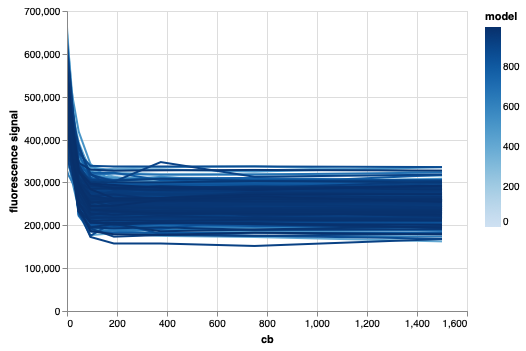

In [186]:
# Define the columns we want to take out
cols = ["fl[1]", "fl[2]", "fl[3]", "fl[4]", "fl[5]",
        "fl[6]", "fl[7]", "fl[8]", "fl[9]", "fl[10]"]
# Take out the columns
df_gen_fl = df_gen[cols]
# Reindex
df_gen_fl = df_gen_fl.stack(level=0)
df_gen_fl = df_gen_fl.reset_index()
df_gen_fl = df_gen_fl.sort_index(level=1)


# Renaming the columns with useful names
df_gen_fl = df_gen_fl.rename(columns={'level_0': 'model', 
                                  'level_1': 'cb',
                                  0:'fluorescence signal'})

# Renaming the conditions with more descriptive names
for i in range(len(cols)):
    df_gen_fl = df_gen_fl.replace({cols[i]:data['cb'][i]})
    
# Take a look
alt.Chart(df_gen_fl).mark_line().encode(
    x = alt.X('cb'),
    y = alt.Y('fluorescence signal'),
    color = alt.Color('model')).interactive()


This looks good! The flourescence values appear to be how we would expect them, in the correct order of magnitude and dependent on cb. Let's code this up into a stan model:

In [187]:
sm2 = bebi103.stan.StanModel(file='./9.2_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_24bec3ba2726d42b5d9d4f3c5d3b8edf NOW.


Load up our data and sample:

In [188]:
data = dict(N=len(df),
           cb=df['b conc (nM)'].values.astype(float),
           fl=df['fluorescence'].values.astype(float))
samples2 = sm2.sampling(data=data, 
                       control=dict(adapt_delta = .9,
                                    max_treedepth = 12),
                       warmup=2000, 
                       iter=10000, 
                       thin=5)
bebi103.stan.check_all_diagnostics(samples2)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0.0 of 6400 (0.0%) iterations ended with a divergence.
0 of 6400 (0.0%) iterations saturated the maximum tree depth of 12.
E-BFMI indicated no pathological behavior.


0

That looks like it worked fine, so let's load it up into a dataframe and take a look:

In [189]:
dfmcmc = bebi103.stan.to_dataframe(samples2, diagnostics=False, inc_warmup=False)
dfmcmc.head()

chain  chain_idx  warmup   Delta_G           f0           fq         sigma  \
0      1          1       0 -1.055459  8984.946251  5366.735466  10058.996180   
1      1          2       0 -0.693232  9102.605017  5382.080649  11321.128298   
2      1          3       0 -0.892595  8753.854892  5337.930915  13517.753624   
3      1          4       0 -1.405322  9114.209304  5107.229231  12722.933257   
4      1          5       0 -1.389227  8565.481656  5136.314739  18029.408104   

         Kd           F[1]           F[2]     ...          fl_ppc[2]  \
0  2.873294  268694.529050  269076.107235     ...      271405.019548   
1  2.000169  269360.276428  269633.958897     ...      278601.601363   
2  2.441456  267183.626019  267490.030533     ...      270591.852222   
3  4.076838  255923.131775  256521.071925     ...      261827.525255   
4  4.011746  257288.760722  257792.381450     ...      259057.277965   

       fl_ppc[3]      fl_ppc[4]      fl_ppc[5]      fl_ppc[6]      fl_ppc[7]  \
0  259486.684226  276975.066907  288446.551663  313515.210782  389125.570229   
1  253714.302518  284725.471700  285625.375266  310525.283766  376032.970583   
2  277998.327274  283904.806568  271342.848430  318139.618830  357583.560910   
3  263814.754863  249857.032371  276111.745806  304501.413160  368203.068639   
4  271474.942826  284859.159399  271487.678051  298164.255001  357335.547232   

       fl_ppc[8]      fl_ppc[9]     fl_ppc[10]        lp__  
0  399832.201503  438350.094355  447940.276977  -93.578339  
1  415062.190509  430488.565476  447299.678142  -94.510106  
2  381742.843430  419244.751608  428952.557091  -95.530356  
3  439665.253947  429711.452387  462996.807143  -95.752134  
4  376898.179079  411921.207475  426914.333744 -101.064611  

[5 rows x 39 columns]

Let's check the corner plot to make sure everything looks the way we would expect:

In [190]:
bokeh.io.show(bebi103.viz.corner(samples2,
                                        pars=['Delta_G', 'f0', 'fq','sigma', 'Kd']))

/Users/julianwagner/anaconda3/lib/python3.7/site-packages/bebi103/viz.py:2555: UserWarning: Rendering so many points without DataShader is ill-advised.
  'Rendering so many points without DataShader is ill-advised.')


Let's look at the posterior predictive check to verify our model is doing what we think:

In [191]:
p = bebi103.viz.predictive_ecdf(samples2,
                                name='fl_ppc', 
                                data=df["fluorescence"],
                                x=np.linspace(200000, 500000),
                                percentiles=[99, 80, 60, 40])
p.plot_width=800

bokeh.io.show(p)

This looks good, but because we lose the cb information in the ECDF format I'd like to also plot the fluorescence values predicting in the posterior predictive checks against the cb values:

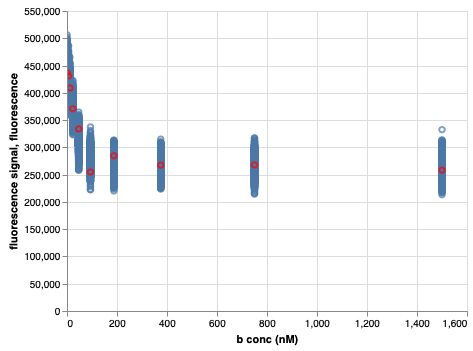

In [192]:
def check_ppc(df):
    # Define the columns we want to take out
    cols = ["fl_ppc[1]", "fl_ppc[2]", "fl_ppc[3]", "fl_ppc[4]", "fl_ppc[5]",
            "fl_ppc[6]", "fl_ppc[7]", "fl_ppc[8]", "fl_ppc[9]", "fl_ppc[10]"]
    # Take out the columns
    df_fl = df[cols]
    # Reindex
    df_fl = df_fl.stack(level=0)
    df_fl = df_fl.reset_index()
    df_fl = df_fl.sort_index(level=1)


    # Renaming the columns with useful names
    df_fl = df_fl.rename(columns={'level_0': 'model', 
                                  'level_1': 'cb',
                                  0:'fluorescence signal'})

    # Renaming the conditions with more descriptive names
    for i in range(len(cols)):
        df_fl = df_fl.replace({cols[i]:data['cb'][i]})
    
    # Take a look
    plot2 = alt.Chart(df_fl).mark_point().encode(
            x = alt.X('cb', title = "b conc (nM)"),
            y = alt.Y('fluorescence signal')).interactive()
    return plot2 + plot1

check_ppc(dfmcmc)

This looks pretty good. We're getting a wide variation around each of the points, likely due to the model trying to catch the outlier. Let's now estimate the Kd from this model:

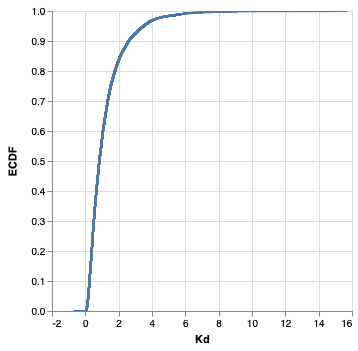

In [181]:
# First let's make a helper plotting function
def make_ecdf(dataframe, data):
    c = altcat.catplot(data=dataframe,
               mark='line',
               encoding=dict(x=alt.X(data,
                                     scale=alt.Scale(
                                           clamp=True))),
               transform='ecdf'
              ).properties(height=300,
                           width=300).interactive()
    return c
# And now apply it
make_ecdf(dfmcmc, "Kd:Q")

This doesn't look like the mean would be a good statistic, so instead let's report the median.

In [182]:
Kd = dfmcmc["Kd"].median() 
Kd

0.8451543421914485

Now let's attempt to deal with the outliers. We will start by using the student t model. The only difference between this model and our original is that we have our data distributed using the student t distribution instead of the Gaussian distribution, so 
$$\text{fl}~ \text{Student_t}(\nu, F(c_a^0), \sigma).$$ 

Where
$\nu$ ~ HalfNorm(1,100), since $\nu$ is bounded by 1 at the bottom and corresponds to how Gaussian the distribution is.

Let's load up this stan model:

In [159]:
sm3 = bebi103.stan.StanModel(file='./9.2_student_model.stan')

Using cached StanModel.


And sample:

In [160]:
samples3 = sm3.sampling(data=data, 
                       control=dict(adapt_delta = .9999999,
                                    max_treedepth = 12),
                       warmup=2000, 
                       iter=10000, 
                       thin=5)
bebi103.stan.check_all_diagnostics(samples3)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0.0 of 6400 (0.0%) iterations ended with a divergence.
0 of 6400 (0.0%) iterations saturated the maximum tree depth of 12.
E-BFMI indicated no pathological behavior.


0

<p style="background-color:#D9EDF7">
Wow, that's a crazy adapt delta!
</p>

Diagnostics look good, let's load this into a dataframe and take a look:

In [161]:
df_student = bebi103.stan.to_dataframe(samples3, diagnostics=False, inc_warmup=False)
df_student.head()

chain  chain_idx  warmup   Delta_G           f0           fq         sigma  \
0      1          1       0 -0.293620  8634.326656  4658.491853  13789.570106   
1      1          2       0 -1.965675  8901.951046  4898.567109   6643.261373   
2      1          3       0 -0.660368  8763.619534  4891.534458   7217.399264   
3      1          4       0  0.030183  8714.641099  4890.617954  10497.276269   
4      1          5       0 -0.875627  8517.383393  4962.755742   7371.161425   

          nu        Kd           F[1]     ...          fl_ppc[2]  \
0  39.979482  0.745560  239429.720492     ...      246444.314947   
1   2.819921  0.140061  251402.928980     ...      242560.443379   
2   4.972770  0.516661  250884.452913     ...      260602.160905   
3   4.239103  1.030643  250821.629636     ...      253784.459335   
4   8.132479  0.416601  253917.273837     ...      276383.164788   

       fl_ppc[3]      fl_ppc[4]      fl_ppc[5]      fl_ppc[6]      fl_ppc[7]  \
0  247657.806035  247228.540718  306630.355239  329824.996440  355779.297837   
1  268641.509083  292930.885718  304430.789038  348879.773477  369456.914928   
2  275999.389740  283555.195183  300826.798187  339765.130699  399758.503087   
3  271937.387993  276115.775863  312375.471885  355665.298150  382681.191651   
4  282768.059844  289843.446579  309547.062322  332872.148371  363095.849439   

       fl_ppc[8]      fl_ppc[9]     fl_ppc[10]        lp__  
0  379065.862381  384510.838598  423691.339507 -100.593778  
1  404574.535472  427156.905308  447733.560792  -99.349089  
2  405579.193494  408252.436879  427303.970003  -97.749142  
3  385338.090827  424731.299452  451645.361290  -97.705019  
4  390917.164787  409864.353584  427693.524206 -102.391659  

[5 rows x 30 columns]

And take a look at the parameters:

In [162]:
bokeh.io.show(bebi103.viz.corner(samples3,
                                        pars=['Delta_G', 'f0', 'fq','sigma', 'nu']))

This looks as expected, so let's take a look at our posterior predictive checks:

In [163]:
p = bebi103.viz.predictive_ecdf(samples3,
                                name='fl_ppc', 
                                data=df["fluorescence"],
                                x=np.linspace(200000, 500000),
                                percentiles=[99, 80, 60, 40])
p.plot_width=800

bokeh.io.show(p)

This seems to fit our values pretty well but let's take a look at the fluorescence values vs the b concentration:

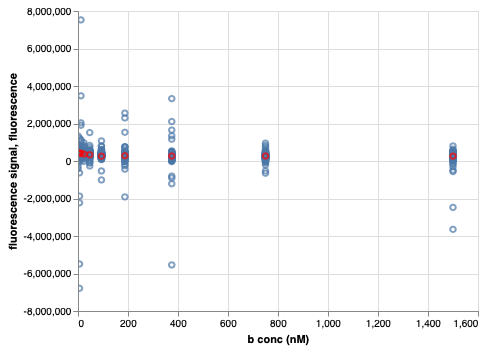

In [164]:
check_ppc(df_student)

This model is generating a lot of outliers to compensate for those in our data set. Let's compare the Kd values for this model and our original:

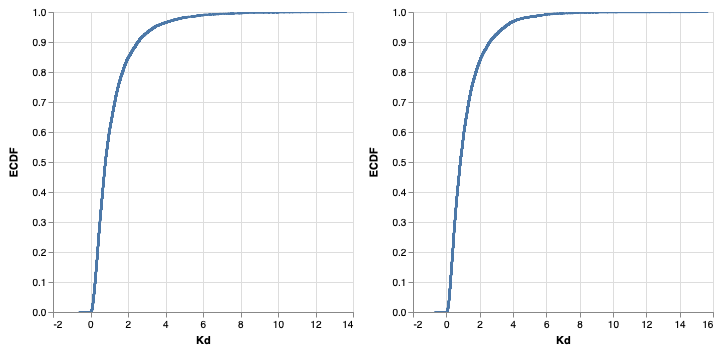

In [165]:
make_ecdf(df_student, "Kd:Q") | make_ecdf(dfmcmc, "Kd:Q")

These look rather similar. Let's compute the median:

In [166]:
Kd2 = df_student["Kd"].median() 
Kd2


0.7946444671517627

Finally, let's use a Good/Bad model for outlier detection and see what effect that has. We thus use a mixture model in which each data point has a probability $w_i$ of being good, with error bar $\sigma$, and otherwise has error bar $\sigma_bad$>$\sigma$. Both of our sigmas will be pulled from the same distribution (HalfNorm(0,5000)) we used in previous models, and our

$w_i$ ~ Beta(2,5)

Let's load up the model:

In [167]:
sm4 = bebi103.stan.StanModel(file='./9.2_good_model.stan')

Using cached StanModel.


And sample:

In [168]:
samples4 = sm4.sampling(data=data, 
                       control=dict(adapt_delta = .9999999,
                                    max_treedepth = 12),
                       warmup=2000, 
                       iter=10000, 
                       thin=5)
bebi103.stan.check_all_diagnostics(samples4)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0.0 of 6400 (0.0%) iterations ended with a divergence.
0 of 6400 (0.0%) iterations saturated the maximum tree depth of 12.
E-BFMI indicated no pathological behavior.


0

Diagnostics look good, let's convert this to a dataframe and take a look:

In [169]:
df_good = bebi103.stan.to_dataframe(samples4, diagnostics=False, inc_warmup=False)
df_good.head()

chain  chain_idx  warmup   Delta_G           f0           fq     sigma[1]  \
0      1          1       0  0.728370  8534.511447  4752.028600  7980.538475   
1      1          2       0 -1.625769  8871.905502  4776.718023  4736.444597   
2      1          3       0  0.460197  8695.732918  4799.998141  5114.296010   
3      1          4       0  0.504066  8714.103238  4968.537754  6661.098745   
4      1          5       0 -0.970725  9006.710480  4829.845901  2030.788839   

       sigma[2]      w[1]      w[2]     ...          fl_ppc[2]      fl_ppc[3]  \
0  13943.274349  0.587548  0.576320     ...      248249.093069  265922.192863   
1  16139.994885  0.149937  0.385739     ...      250878.354677  263728.162677   
2  19623.757424  0.581150  0.043720     ...      255057.173916  254095.768312   
3  18466.976541  0.793173  0.069261     ...      247310.836271  282160.730661   
4  17029.344517  0.526570  0.136094     ...      273169.879639  265164.589587   

       fl_ppc[4]      fl_ppc[5]      fl_ppc[6]      fl_ppc[7]      fl_ppc[8]  \
0  278068.334243  294880.201895  324482.092508  374993.470781  385018.663441   
1  272360.359729  305837.475447  350265.188189  386961.528011  401460.132209   
2  277615.341533  309621.535274  346707.691149  321903.186217  396819.275348   
3  303134.232883  309298.739505  352111.102026  391367.294375  397816.836161   
4  284280.810508  304870.082171  340791.385287  366196.786311  424265.976412   

       fl_ppc[9]     fl_ppc[10]        lp__  
0  419532.526380  427933.935104 -123.678946  
1  428819.069973  463368.464067 -122.602325  
2  397356.602270  391974.873418 -119.045580  
3  416071.365482  404664.723642 -126.623060  
4  450232.618427  448376.836053 -121.074073  

[5 rows x 40 columns]

Take a look at parameters:

In [170]:
bokeh.io.show(bebi103.viz.corner(samples4,
                                        pars=['Delta_G', 'f0', 'fq','sigma[1]','sigma[2]']))

There's some odd clustering with the sigma[1] and the f0 and fq values, but no divergences. Let's do our posterior predictive checks:

In [171]:
p = bebi103.viz.predictive_ecdf(samples4,
                                name='fl_ppc', 
                                data=df["fluorescence"],
                                x=np.linspace(200000, 500000),
                                percentiles=[99, 80, 60, 40])
p.plot_width=800

bokeh.io.show(p)

This model clearly fits our data well.

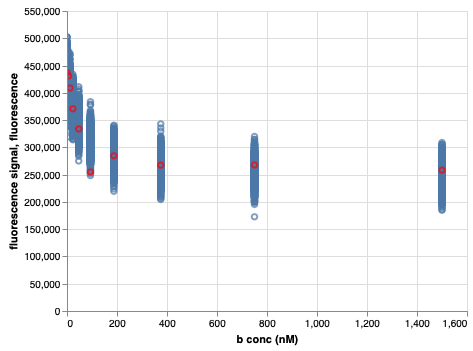

In [172]:
check_ppc(df_good)

This model is more reminiscent of the original model than the student-t one as it is generating far fewer large outliers, but it still incorporates all our data.

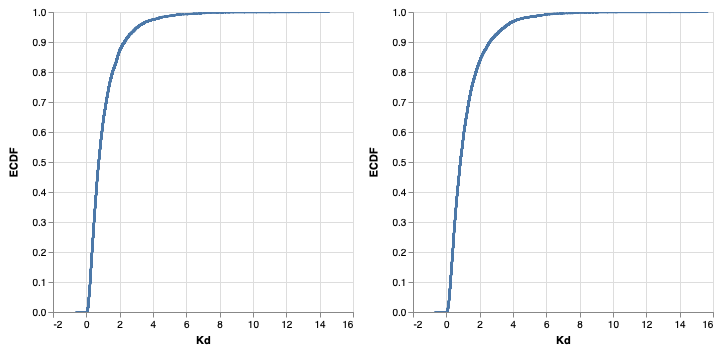

In [173]:
make_ecdf(df_good, "Kd:Q") | make_ecdf(dfmcmc, "Kd:Q")

These also look very similar. Let's report the value of the median:

In [174]:
Kd3 = df_good["Kd"].median()
Kd3

0.7457973527524944

Finally, let's report the values predicted for Kd by each of the models we used to compare:

In [175]:
df_res = pd.DataFrame(columns=['method', 'hbd_low', 'median', 'hbd_high'])
kd_samples = samples2.extract('Kd')['Kd']
df_res = df_res.append(pd.DataFrame({'method': ['mcmc'],
                                     'hbd_low': [bebi103.stan.hpd(kd_samples, mass_frac=0.95)[0]],
                                     'median': [np.median(kd_samples)],
                                     'hbd_high': [bebi103.stan.hpd(kd_samples, mass_frac=0.95)[1]]}),
                      ignore_index=True)
    
kd_samples = samples3.extract('Kd')['Kd']
df_res = df_res.append(pd.DataFrame({'method': ['student_t'],
                                     'hbd_low': [bebi103.stan.hpd(kd_samples, mass_frac=0.95)[0]],
                                     'median': [np.median(kd_samples)],
                                     'hbd_high': [bebi103.stan.hpd(kd_samples, mass_frac=0.95)[1]]}),
                      ignore_index=True)
    
kd_samples = samples4.extract('Kd')['Kd']
df_res = df_res.append(pd.DataFrame({'method': ['good_bad'],
                                     'hbd_low': [bebi103.stan.hpd(kd_samples, mass_frac=0.95)[0]],
                                     'median': [np.median(kd_samples)],
                                     'hbd_high': [bebi103.stan.hpd(kd_samples, mass_frac=0.95)[1]]}),
                      ignore_index=True)


    
# Take a look
df_res

method   hbd_low    median  hbd_high
0       mcmc  0.040372  0.845154  3.501259
1  student_t  0.031761  0.794644  3.426593
2   good_bad  0.034805  0.745797  3.085336

The good_bad model has a tighter distribution of Kd values than either of the other two models, and the median value for Kd is lower for the good_bad model than the other two. The student_t model and the original model yield very similar values for Kd.

Finally, I will print all the stan code used here.

In [176]:
print("-------------MODEL CHECK 1-------------")
print(sm.model_code)
print("-------------MODEL CHECK 2-------------")
print(sm2.model_code)
print("-------------MODEL CHECK 3-------------")
print(sm3.model_code)
print("-------------MODEL CHECK 4-------------")
print(sm4.model_code)

-------------MODEL CHECK 1-------------
data{
    int N;
    real cb[N];
}

generated quantities{
    // Parameters
    real Delta_G;
    real<lower=0> Kd;
    real<lower=0> f0;
    real<lower=0> fq;
    real<lower=0> sigma;

    real<lower=0> ca;
    vector[N] F;
    vector[N] fl;
       
    Delta_G = normal_rng(0,1); 
    Kd = exp(Delta_G);
    f0 = normal_rng(10000, 1000);
    fq = normal_rng(5000, 500);
    sigma = fabs(normal_rng(0, 5000));

    ca = 50;
    
    // Data
    for (i in 1:N) {
        F[i] = f0 * ca - (2 * (f0 - fq) * ca * cb[i]) / (Kd + ca + cb[i] + sqrt(square(Kd + ca + cb[i]) - 4 * ca * cb[i]));
        fl[i] = normal_rng(F[i], sigma);
    }
}
-------------MODEL CHECK 2-------------
data{
    int N;
    real cb[N];
    real fl[N];
    
}

parameters{
    real Delta_G;
    real f0;
    real fq;

    real<lower=0> sigma;
}

transformed parameters{
    real Kd;
    real F[N];
    
    Kd = exp(Delta_G);
    for (i in 1:N) {
        F[i] = f0 * 50 - (2 * (f0 - fq) *